In [22]:
import pandas as pd
from pandas.tseries.offsets import BDay

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = True
percentageOfRemovedDays = 40

In [23]:
def plot_prices_volatilities_for_rw(stock_prices, real_volatility, real_volatility_startDate, real_volatility_endDate, rw_volatility, asset_name):
    '''
    Function to plot prices and volatilities for rolling window
    '''
     # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 11), sharex=True)

    # Plot stock prices
    ax1.plot(stock_prices[asset_name], label=f'{asset_name} Price', color='green')
    ax1.set_title(f'{asset_name} Stock Prices')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    
    # Plot real and rolling window volatilities
    ax2.plot(real_volatility_filtered, label=f'Real {asset_name} Volatility', color='blue')
    ax2.plot(rw_volatility, label=f'RW {asset_name} Volatility', color='orange', linestyle='--')
    ax2.set_title(f'{asset_name} Volatility: Real vs Rolling Window')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volatility')
    ax2.legend(loc='upper left')

    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax2.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    
    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax2.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Import Data

In [24]:
stocksPrices = pd.read_csv('data/stocksPrices.csv', index_col=0, parse_dates=True)
stocksPercentageChangeReturn = pd.read_csv('data/stocksPercentageChange.csv', index_col=0, parse_dates=True)
uniformlyDistributedReturns = stocksPercentageChangeReturn.copy() # this is a copy of the original dataset returns; i will use this to make it non-uniformly distributed

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# i have 13 years of trading data; 3273 days; now i will split the dataset into 70% training, 20% validation and 10% test

total_days = len(stocksPrices)
date_70_percent = stocksPrices.index[int(total_days * 0.7)]
date_90_percent = stocksPrices.index[int(total_days * 0.9)]

# 70% training
trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

# Adjust the start date for the validation set to exclude the last date of the training set
validation_start_date = date_70_percent + BDay(1)

# 20% validation
validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

# Adjust the start date for the test set to exclude the last date of the validation set
test_start_date = date_90_percent + BDay(1)

# 10% test
testDataWithPrices = stocksPrices.loc[test_start_date:]
testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]

# print the first date and the last date of each dataset
print("First date of training dataset: ", trainingDataWithPrices.index[0])
print("Last date of training dataset: ", trainingDataWithPrices.index[-1])
print("len of training dataset: ", len(trainingDataWithPrices))

print("\nFirst date of validation dataset: ", validationDataWithPrices.index[0])
print("Last date of validation dataset: ", validationDataWithPrices.index[-1])
print("len of validation dataset: ", len(validationDataWithPrices))

print("\nFirst date of test dataset: ", testDataWithPrices.index[0])
print("Last date of test dataset: ", testDataWithPrices.index[-1])
print("len of test dataset: ", len(testDataWithPrices))

print("\ntotal dataset lenght: ", len(stocksPrices))
print("sum of the three datasets: ", len(trainingDataWithPrices) + len(validationDataWithPrices) + len(testDataWithPrices))

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272


In [25]:
print("original returns dataframe dimension: " + str(stocksPercentageChangeReturn.shape))

# Import pickle
with open('data/permco_to_ticker.pkl', 'rb') as f:
    permco_to_ticker = pickle.load(f)

# Create a reverse mapping if necessary
ticker_to_permco = {v: k for k, v in permco_to_ticker.items()}

# Replace ticker symbols with PERMCO codes if the ticker symbol is found in the reverse mapping
columns = [ticker_to_permco.get(col, col) for col in stocksPercentageChangeReturn.columns]
stocksPercentageChangeReturn.columns = columns

# Repeat for uniformlyDistributedReturns
columns_udr = [ticker_to_permco.get(col, col) for col in uniformlyDistributedReturns.columns]
uniformlyDistributedReturns.columns = columns_udr

original returns dataframe dimension: (3272, 3)


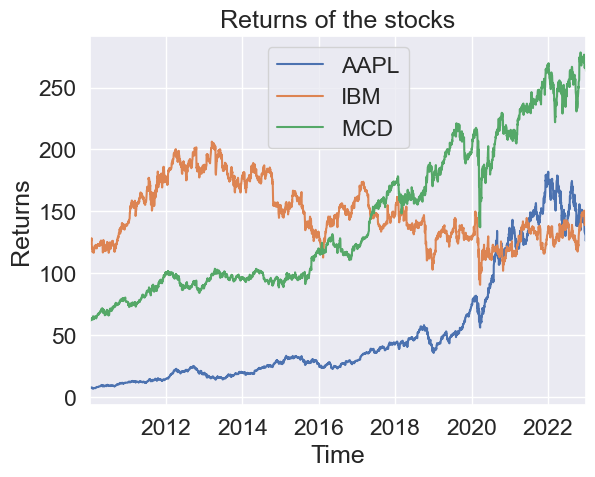

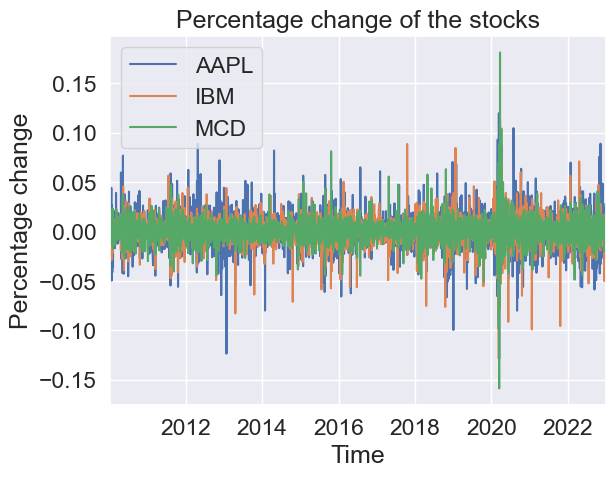

In [26]:
# plot the returns of the stocks
plt.plot(stocksPrices)

# write a legend: the green line is aapl; the blue line is ibm; the red line is mcd(this is just an example)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Returns of the stocks")
plt.xlabel("Time")
plt.ylabel("Returns")

# Set x-axis limits to match the start and end dates
plt.xlim(left=stocksPrices.index[0], right=stocksPrices.index[-1])
plt.show()


# plot also the percentage change of the stocks
plt.plot(stocksPercentageChangeReturn)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Percentage change of the stocks")
plt.xlabel("Time")
plt.ylabel("Percentage change")

# Set x-axis limits to match the start and end dates
plt.xlim(left=stocksPercentageChangeReturn.index[0], right=stocksPercentageChangeReturn.index[-1])
plt.show()

# Dictionary Initialization

In [27]:
rw_memory = 10

# Open a file to save the results
with open('rwPerformance.txt', 'w') as file:
    file.write('')  # Header for the text file

prescientDict = {}
log_likelihoods = {}
regrets = {}

# create a dictionary for every predictor that saves the log-likelihoods and the regrets
log_likelihood_rw = {}
log_likelihood_prescient = {}

regret_rw = {}
regret_prescient = {}

# collections for plotting charts about the performance of the RW predictor
rwValues = []
rwMeanRegretValues = []
rwMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

days_greater_than_one_values = []  # To store determinant values where > 1
days_less_than_one_values = []  # To store determinant values where < 1

# Covariance Predictors

PRESCIENT(GROUND TRUTH)

In [28]:
# THIS CODE IS CALCULATING THE REAL VOLATILITY

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

for t in uniformlyDistributedReturns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, axis=0)
    prescientDict[t] = pd.DataFrame(cov+np.outer(mean, mean), index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

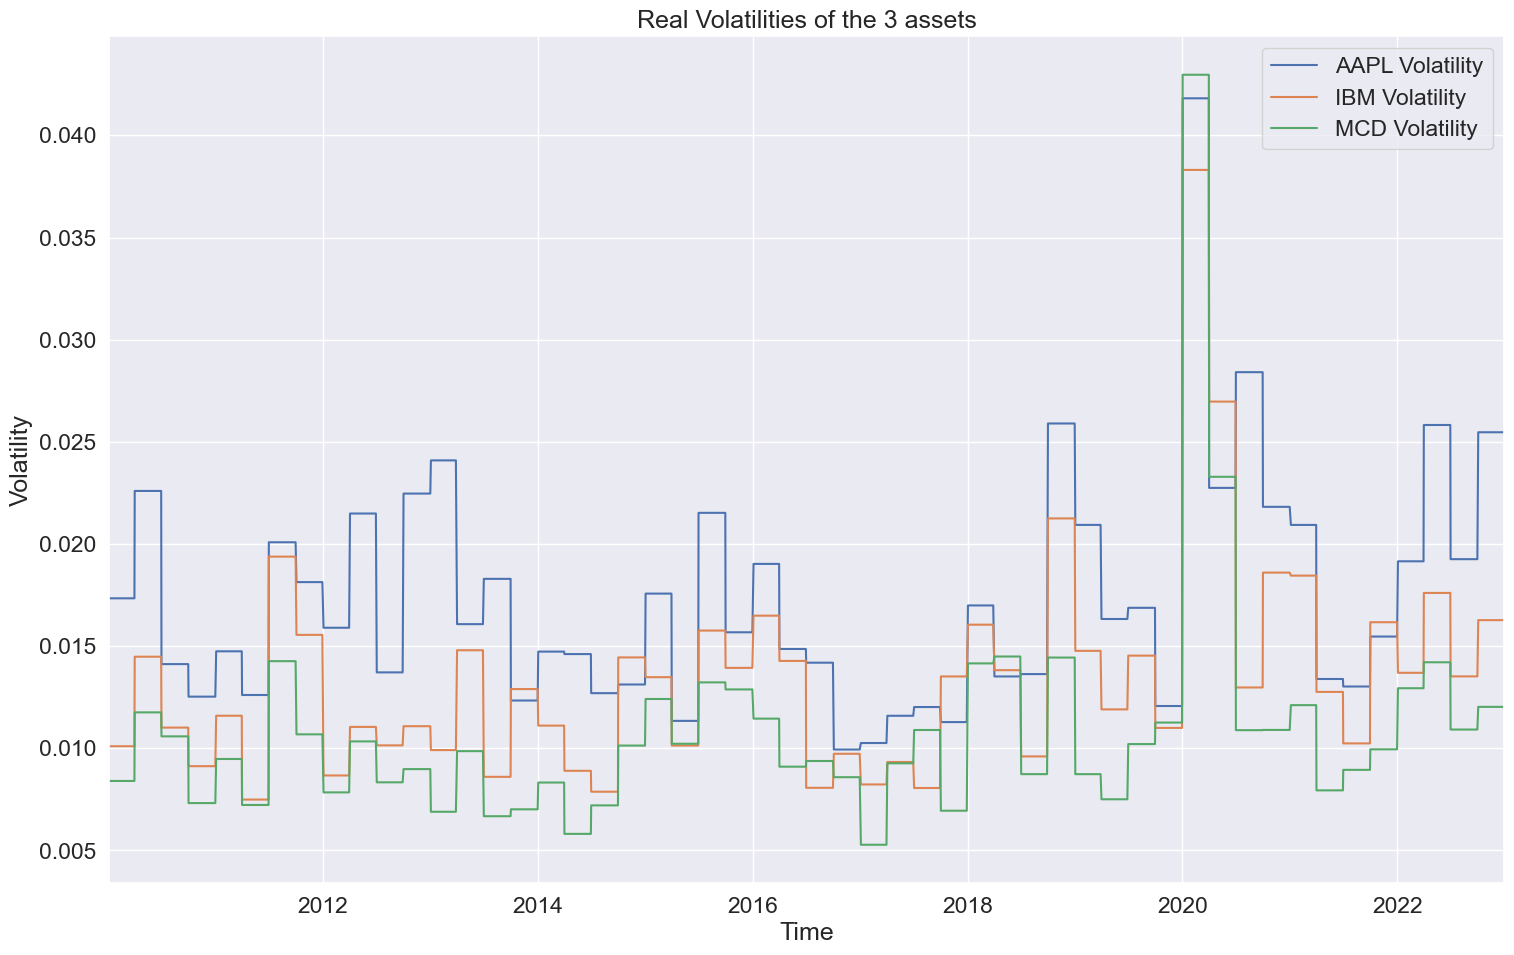

In [29]:
# THIS IS THE VISUALIZATION OF THE REAL VOLAITILITIES OF THE 3 ASSETS

# now calculates/extract the real volatilities of the 3 assets
real_volatilities = {}

for date, cov_matrix in prescientDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    real_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now real_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the prescientDict dictionary(the timestamp)

# now separate the real volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl = {}
volatility_dict_ibm = {}
volatility_dict_mcd = {}

for date, volatilities in real_volatilities.items():
    volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl = pd.DataFrame(list(volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm = pd.DataFrame(list(volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd = pd.DataFrame(list(volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl.set_index('Date', inplace=True)
df_volatility_ibm.set_index('Date', inplace=True)
df_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl, label='AAPL Volatility')
plt.plot(df_volatility_ibm, label='IBM Volatility')
plt.plot(df_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Real Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_volatility_aapl.index[0], right=df_volatility_aapl.index[-1])
plt.show()

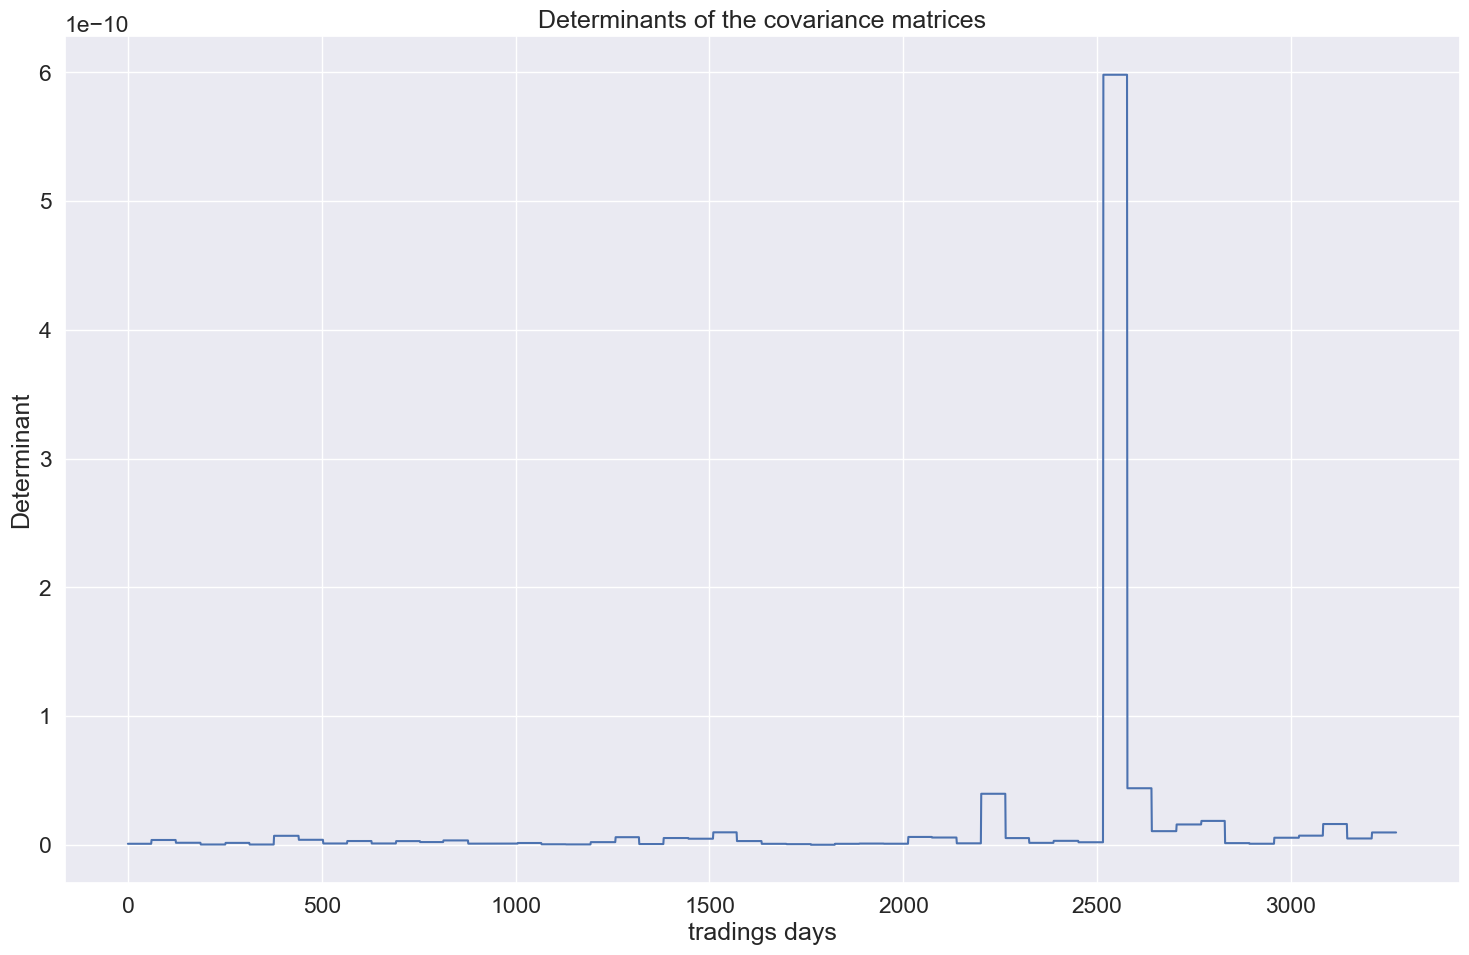

In [30]:
# HERE THERE IS A BRIEF STUDY OF THE DETERMINANTS OF THE COVARIANCE MATRICES; SO THIS EXPLAINS WHY THE LOG LIKELIHOOD OF THE PRESCIENT PREDICTOR IS POSITIVE
# this because from the chart is clear that for every trading day the determinant of the covariance matrix is lower than 1; so the log term became positive

# now let's study why the prescient predictor has a positive log-likelihood and a 0 regret: i make a list off all the determinants of the covariance matrices and i plot them
determinants = []
for date, cov_matrix in prescientDict.items():
    determinants.append(np.linalg.det(cov_matrix))

# in particular i want to se if it is greater than 1 or not
plt.figure(figsize=(18, 11))
plt.plot(determinants)
plt.title("Determinants of the covariance matrices")
plt.xlabel("tradings days")
plt.ylabel("Determinant")
plt.show()

FOR THE RW PREDICTOR THERE IS NO TRAINING PHASE, THE PREDICTOR HAS M(window memory) AS UNIQUE PARAMETER AND IT IS AN HYPERPARAMETER. 
The best value for M has been found with the grid search method applied in the validation phase.

# Validation Phase for RW predictor

In [31]:
# Loop through rw_memory values

def rwValidationPhase(rw_memory, startingDate, endingDate, rw_size_increment, prescientAlreadyPrinted):
    '''
    this function is used to perform the validation phase of the RW predictor; it's used to find the best memory size of the window for the rw predictor.
    Grid search is used and the performance of the M hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while rw_memory < 700:

        rwDict = rolling_window(validationDataWithPercentageChange, rw_memory) 

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
            
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        names = ["RW", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [rwDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

        #
        # MSEs
        #
            
        for i, predictorDict in enumerate(predictors):
            if names[i] != "PRESCIENT":
                MSE_temp = MSE(validationDataWithPercentageChange, predictorDict).resample("Q").mean()

                # write the results in the file
                with open('rwPerformance.txt', 'a') as file:
                    file.write(f'RWMEMORY:\t\t\t{rw_memory}\nMSEmean: {MSE_temp.mean():.6f}\nMSEstd: {MSE_temp.std():.6f}\nMSEmax: {MSE_temp.max():.6f}\n\n')


        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            if names[i] == "PRESCIENT":
                returns_temp = validationDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
            
            else:
                returns_temp = validationDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]

            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

        #
        # REGRETS
        #

        for name in log_likelihoods:
            regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]
            
        for name in regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                rwMeanRegretValues.append(regretMetrics[0])

                # write the results in the file
                with open('rwPerformance.txt', 'a') as file:
                    file.write(f'meanRegret: {regretMetrics[0]:.2f}\nstdRegret: {regretMetrics[1]:.2f}\nmaxRegret: {regretMetrics[2]:.2f}\n\n')


        # copy the log-likelihoods dictionary
        log_likelihoods_copy = log_likelihoods.copy()

        # do the same thing for log-likelihoods dictionary
        for name in log_likelihoods_copy:
            logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

            if name != "PRESCIENT":
                # save the log-likelihood mean values to plot a chart
                rwMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])

                # write the results in the file
                with open('rwPerformance.txt', 'a') as file:
                    file.write(f'meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.2f}\nstdLoglikelihood{name}: {logLikelihoodMetrics[1]:.2f}\nmaxLoglikelihood{name}: {logLikelihoodMetrics[2]:.2f}\n\n')
            
            if name == "PRESCIENT" and prescientAlreadyPrinted == False:
            # write the results in the file so i'm writing the prescient predictor only once, because it's the same for every beta
                with open('rwPerformance.txt', 'a') as file:
                    file.write(f'meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.2f}\nstdLoglikelihood{name}: {logLikelihoodMetrics[1]:.2f}\nmaxLoglikelihood{name}: {logLikelihoodMetrics[2]:.2f}\n\n')
                prescientAlreadyPrinted = True

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValue = logLikelihoodMetrics[0]
        
        # save the rw value to plot a chart
        rwValues.append(rw_memory)

        # Increment beta
        rw_memory += rw_size_increment

    # return the fundamental values to plot the charts
    return rwValues, rwMeanRegretValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue

In [32]:
# this function is used to plot the performance of the RW predictor in terms of regret and log-likelihood

def plotLogLikelihoodPerformanceRW(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue):
    '''
    plot the chart of the mean log-likelihood value
    '''

    rwMinValuesLogLikelihood = [] # this list will contain the rw values that have the max log-likelihood value
    plt.figure()
    plt.plot(rwValues, rwMeanlogLikelihoodValues)
    plt.title("Mean log-likelihood values of the RW predictor")
    plt.xlabel("RW memory")
    plt.ylabel("Mean log-likelihood")
    plt.title("Mean log-likelihood values of the RW predictor")

    # show also the loglikelihood value of the prescient predictor
    plt.axhline(y=prescientMeanlogLikelihoodValue, color='r', linestyle='-')
    plt.legend(["RW", "PRESCIENT"])

    # find the rw values that have the max log-likelihood value
    for j in range(len(rwMeanlogLikelihoodValues)):
        if rwMeanlogLikelihoodValues[j] == max(rwMeanlogLikelihoodValues):
            rwMinValuesLogLikelihood.append(rwValues[j])

    # these points show the interval of rw values that have the maximum log-likelihood value
    highlightsPoint1 = rwMinValuesLogLikelihood[0]
    plt.scatter(highlightsPoint1, max(rwMeanlogLikelihoodValues), color='r')
    #plt.text(highlightsPoint1, max(rwMeanlogLikelihoodValues), f' M: {highlightsPoint1:.1f}\n Log-likelihood: {max(rwMeanlogLikelihoodValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')

    highlightsPoint2 = rwMinValuesLogLikelihood[-1]
    plt.scatter(highlightsPoint2, max(rwMeanlogLikelihoodValues), color='r')
    #plt.text(highlightsPoint2, max(rwMeanlogLikelihoodValues), f' M: {highlightsPoint2:.1f}\n Log-likelihood: {max(rwMeanlogLikelihoodValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')
    
    # find the y value coordinate corresponding to the highlightPoint1LogLikelihood and highlightPoint2LogLikelihood
    highlightsPoint1Index = rwValues.index(highlightsPoint1)
    highlightsPoint2Index = rwValues.index(highlightsPoint2)

    highlightsPoint1Y = rwMeanlogLikelihoodValues[highlightsPoint1Index]
    highlightsPoint2Y = rwMeanlogLikelihoodValues[highlightsPoint2Index]

    print(f"rwMemory: {highlightsPoint1:.4f}\n Log-likelihood: {highlightsPoint1Y:.4f}")
    print(f"rwMemory: {highlightsPoint2:.4f}\n Log-likelihood: {highlightsPoint2Y:.4f}")

    # set the x-axis limits
    plt.xlim(left=10, right=600)

    plt.show()


def plotRegretPerformanceRW(rwValues, rwMeanRegretValues):
    '''
    plot the chart of the mean regret values
    '''

    rwMinValuesRegret = [] # this list will contain the rw values that have the min regret value
    plt.plot(rwValues, rwMeanRegretValues)
    plt.title("Mean regret values of the RW predictor")
    plt.xlabel("RW memory")
    plt.ylabel("Mean regret")
    plt.title("Mean regret values of the RW predictor")

    # find the rw values that have the min regret value
    for i in range(len(rwMeanRegretValues)):
        if rwMeanRegretValues[i] == min(rwMeanRegretValues):
            rwMinValuesRegret.append(rwValues[i])

    # these points show the interval of rw values that have the minimum regret value
    highlightsPoint1 = rwMinValuesRegret[0]
    plt.scatter(highlightsPoint1, min(rwMeanRegretValues), color='r')
    #plt.text(highlightsPoint1, min(rwMeanRegretValues), f' rwMemory: {highlightsPoint1:.1f} \n Regret: {min(rwMeanRegretValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')

    highlightsPoint2 = rwMinValuesRegret[-1]
    plt.scatter(highlightsPoint2, min(rwMeanRegretValues), color='r')
    #plt.text(highlightsPoint2, min(rwMeanRegretValues), f' rwMemory: {highlightsPoint2:.1f} \n Regret: {min(rwMeanRegretValues):.4f}', fontsize=9, color='red', ha='center', va='bottom')
    
    # find the y value coordinate corresponding to the highlightPoint1Regret and highlightPoint2Regret
    highlightsPoint1Index = rwValues.index(highlightsPoint1)
    highlightsPoint2Index = rwValues.index(highlightsPoint2)

    highlightsPoint1Y = rwMeanRegretValues[highlightsPoint1Index]
    highlightsPoint2Y = rwMeanRegretValues[highlightsPoint2Index]

    print(f"rwMemory: {highlightsPoint1:.4f}\n Regret: {highlightsPoint1Y:.4f}")
    print(f"rwMemory: {highlightsPoint2:.4f}\n Regret: {highlightsPoint2Y:.4f}")

    # set the x-axis limits
    plt.xlim(left=10, right=600)

    plt.show()

In [33]:
# first of all define the starting and ending date for the validation phase: take the first and the last date of the validation dataset

startingValidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

rwMemory: 30.0000
 Log-likelihood: 8.3000
rwMemory: 70.0000
 Log-likelihood: 8.3000


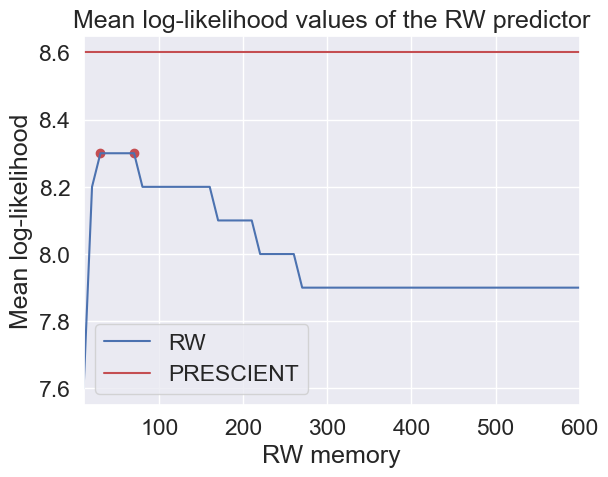

rwMemory: 30.0000
 Regret: 0.3000
rwMemory: 50.0000
 Regret: 0.3000


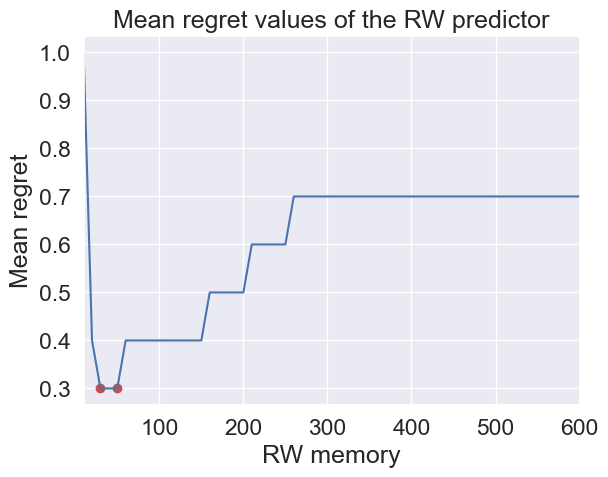

In [34]:
# grid search run for the RW predictor
rwValues, rwMeanRegretValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = rwValidationPhase(10, startingValidationDate, endingValidationDate, 10, prescientAlreadyPrinted)

# plot the performance of the RW predictor in terms of log-likelihood
plotLogLikelihoodPerformanceRW(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)

# plot the performance of the RW predictor in terms of regret
plotRegretPerformanceRW(rwValues, rwMeanRegretValues)

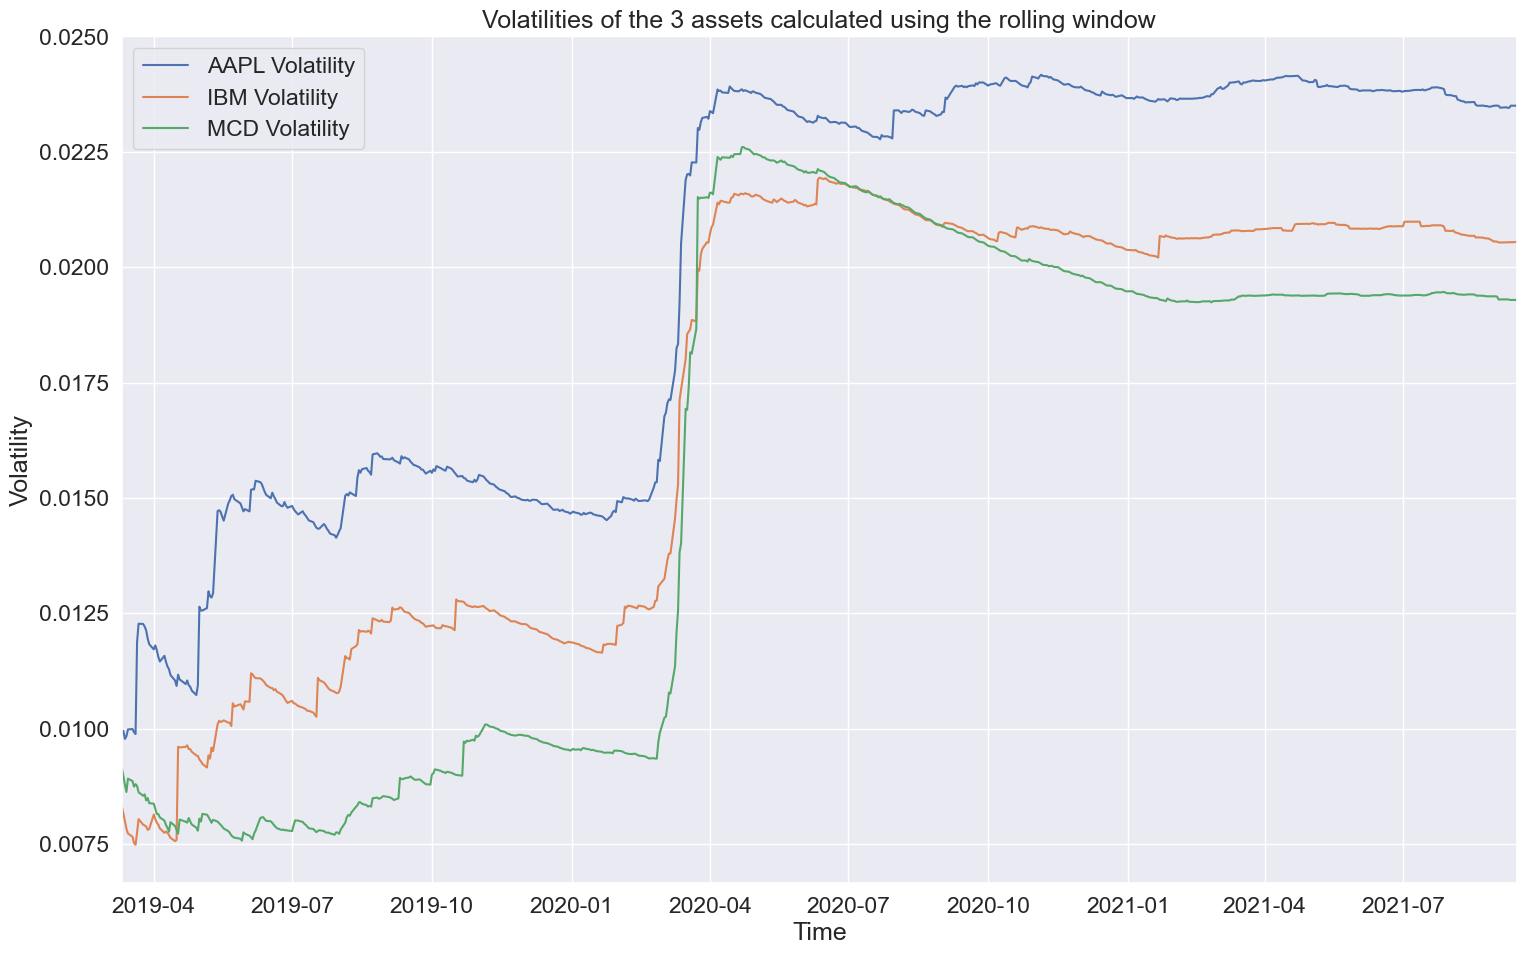

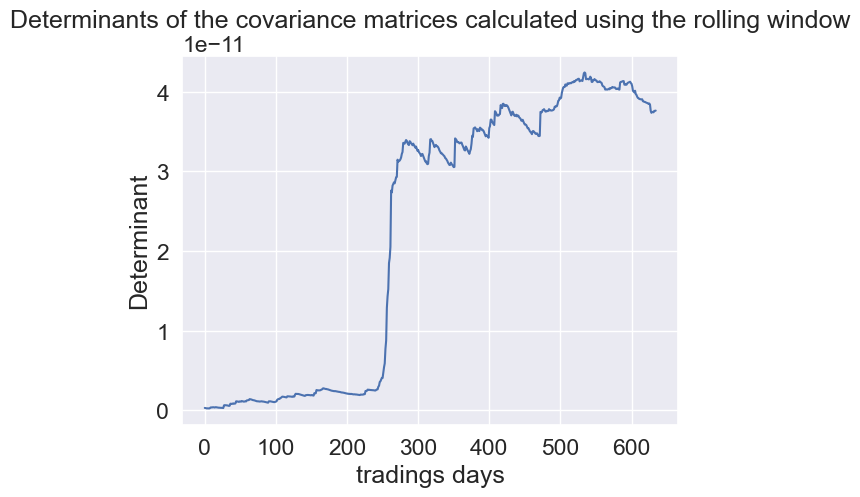

In [45]:
# prepare the date for the test phase

startingTestDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best memory size for the RW predictor(the one found in the validation phase)

rw_memory = 500

rwDict = rolling_window(validationDataWithPercentageChange, rw_memory)

rw_volatilities = {}

for date, cov_matrix in rwDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    rw_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now rw_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the rwDict dictionary(the timestamp)
    
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# filter the dictionary
rw_volatilities = {k: v for k, v in rw_volatilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}
# now separate the real volatilities of the 3 assets in 3 different dataframes
rw_volatility_dict_aapl = {}
rw_volatility_dict_ibm = {}
rw_volatility_dict_mcd = {}

for date, volatilities in rw_volatilities.items():
    rw_volatility_dict_aapl[date] = volatilities.loc["AAPL"]["volatility"] # 7 is the PERMCO code of AAPL
    rw_volatility_dict_ibm[date] = volatilities.loc["IBM"]["volatility"] # 20990 is the PERMCO code of IBM
    rw_volatility_dict_mcd[date] = volatilities.loc["MCD"]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_rw_volatility_aapl = pd.DataFrame(list(rw_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_rw_volatility_ibm = pd.DataFrame(list(rw_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_rw_volatility_mcd = pd.DataFrame(list(rw_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_rw_volatility_aapl.set_index('Date', inplace=True)
df_rw_volatility_ibm.set_index('Date', inplace=True)
df_rw_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_rw_volatility_aapl, label='AAPL Volatility')
plt.plot(df_rw_volatility_ibm, label='IBM Volatility')
plt.plot(df_rw_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the rolling window")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_rw_volatility_aapl.index[0], right=df_rw_volatility_aapl.index[-1])
plt.show()

# now i study the determinants of the covariance matrices calculated using the rolling window
rw_determinants = []
for date, cov_matrix in rwDict.items():
    rw_determinants.append(np.linalg.det(cov_matrix))

# in particular i want to se if it is greater than 1 or not
plt.plot(rw_determinants)
plt.title("Determinants of the covariance matrices calculated using the rolling window")
plt.xlabel("tradings days")
plt.ylabel("Determinant")

plt.show()

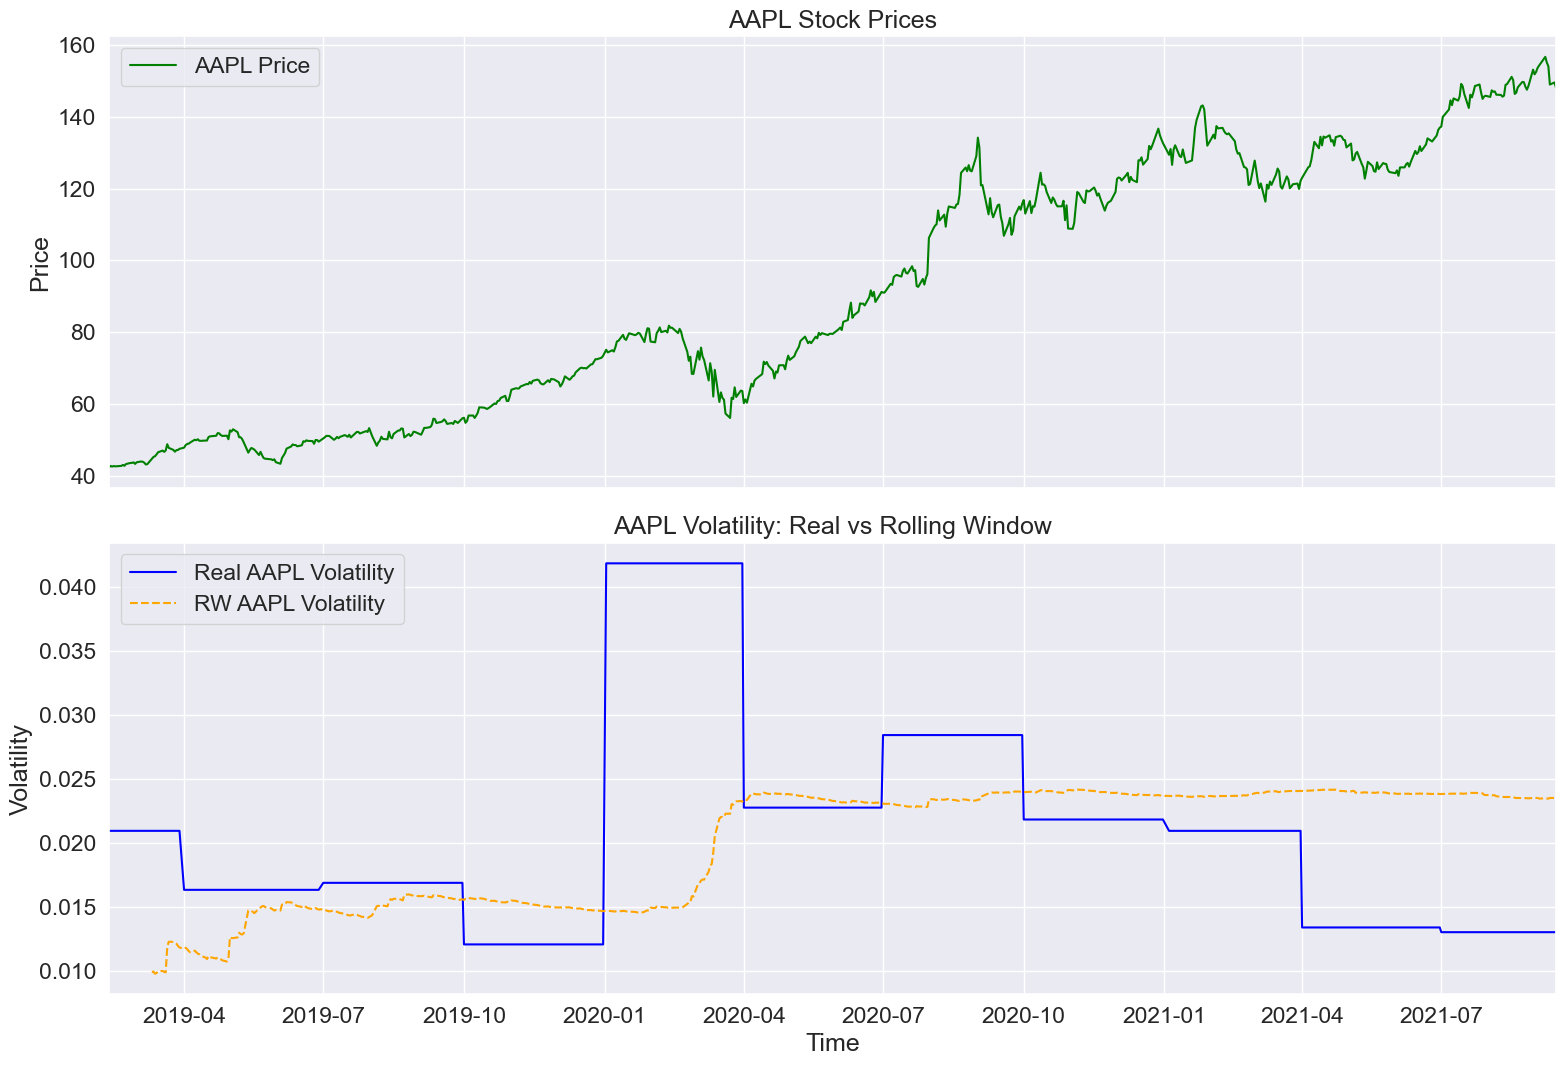

In [46]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_rw(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')

# Test Phase for RW predictor

In this test phase i will use the best value for rw_memory found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

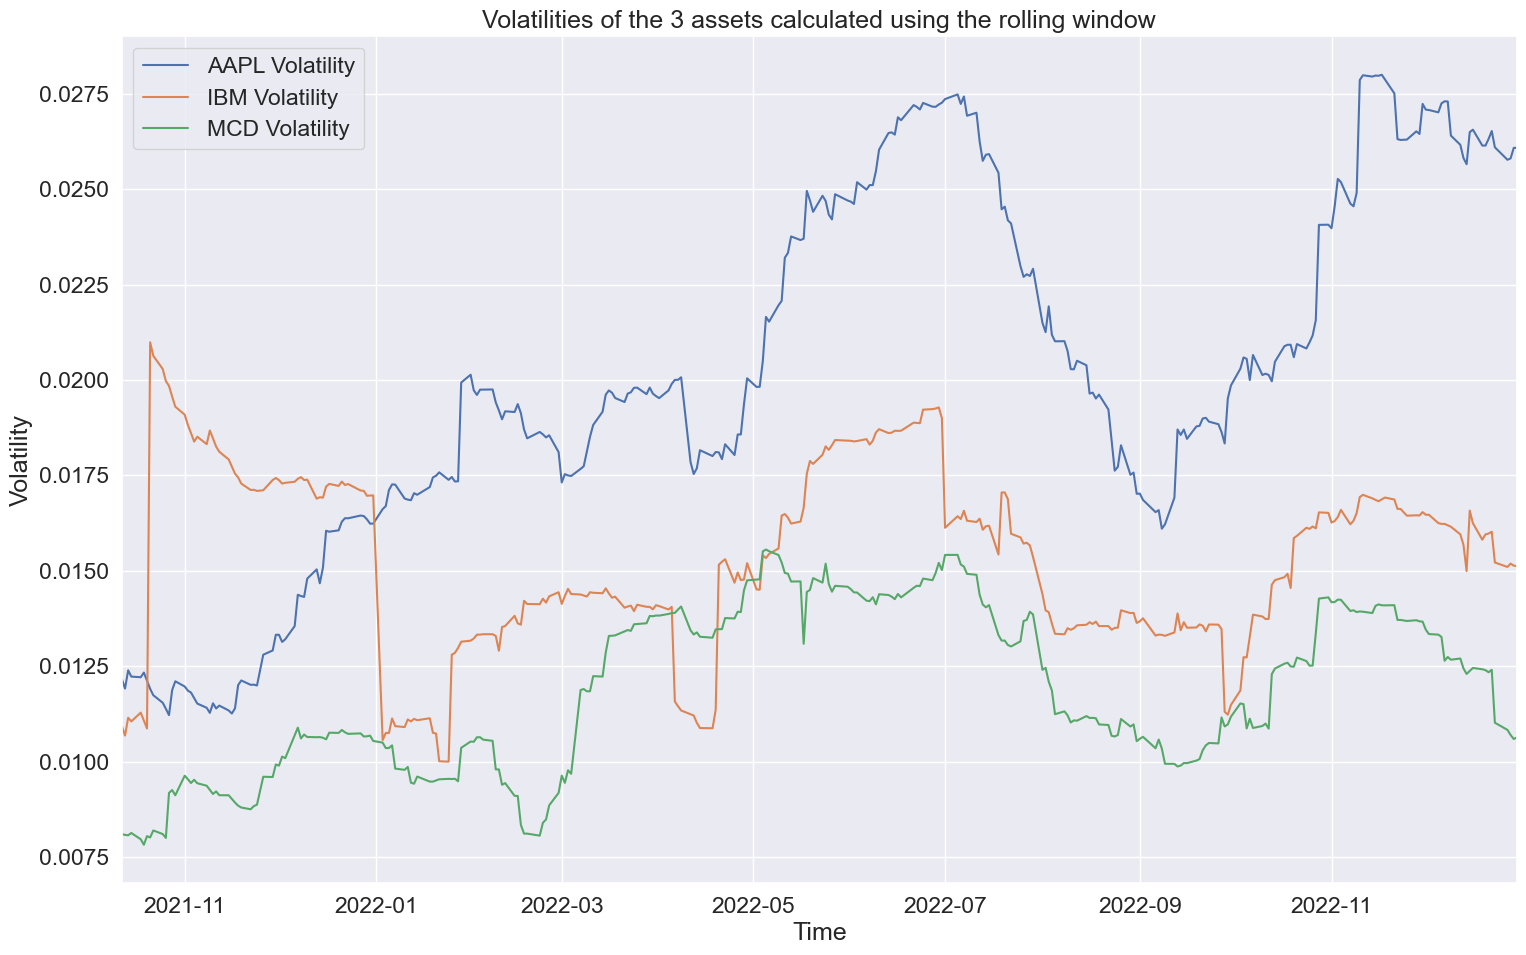

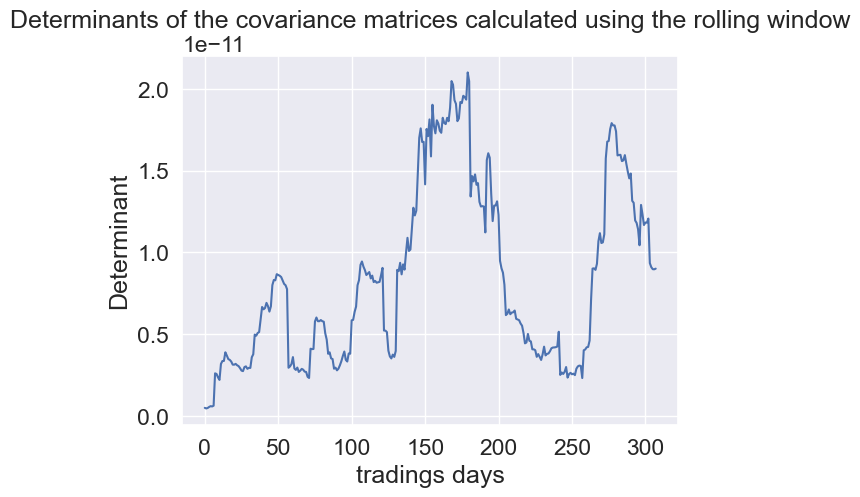

In [47]:
# prepare the date for the test phase

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best memory size for the RW predictor(the one found in the validation phase)

rw_memory = 50

rwDict = rolling_window(testDataWithPercentageChange, rw_memory)

rw_volatilities = {}

for date, cov_matrix in rwDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    rw_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now rw_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the rwDict dictionary(the timestamp)
    
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# filter the dictionary
rw_volatilities = {k: v for k, v in rw_volatilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}
# now separate the real volatilities of the 3 assets in 3 different dataframes
rw_volatility_dict_aapl = {}
rw_volatility_dict_ibm = {}
rw_volatility_dict_mcd = {}

for date, volatilities in rw_volatilities.items():
    rw_volatility_dict_aapl[date] = volatilities.loc["AAPL"]["volatility"] # 7 is the PERMCO code of AAPL
    rw_volatility_dict_ibm[date] = volatilities.loc["IBM"]["volatility"] # 20990 is the PERMCO code of IBM
    rw_volatility_dict_mcd[date] = volatilities.loc["MCD"]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_rw_volatility_aapl = pd.DataFrame(list(rw_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_rw_volatility_ibm = pd.DataFrame(list(rw_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_rw_volatility_mcd = pd.DataFrame(list(rw_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_rw_volatility_aapl.set_index('Date', inplace=True)
df_rw_volatility_ibm.set_index('Date', inplace=True)
df_rw_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_rw_volatility_aapl, label='AAPL Volatility')
plt.plot(df_rw_volatility_ibm, label='IBM Volatility')
plt.plot(df_rw_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the rolling window")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_rw_volatility_aapl.index[0], right=df_rw_volatility_aapl.index[-1])
plt.show()

# now i study the determinants of the covariance matrices calculated using the rolling window
rw_determinants = []
for date, cov_matrix in rwDict.items():
    rw_determinants.append(np.linalg.det(cov_matrix))

# in particular i want to se if it is greater than 1 or not
plt.plot(rw_determinants)
plt.title("Determinants of the covariance matrices calculated using the rolling window")
plt.xlabel("tradings days")
plt.ylabel("Determinant")
plt.show()

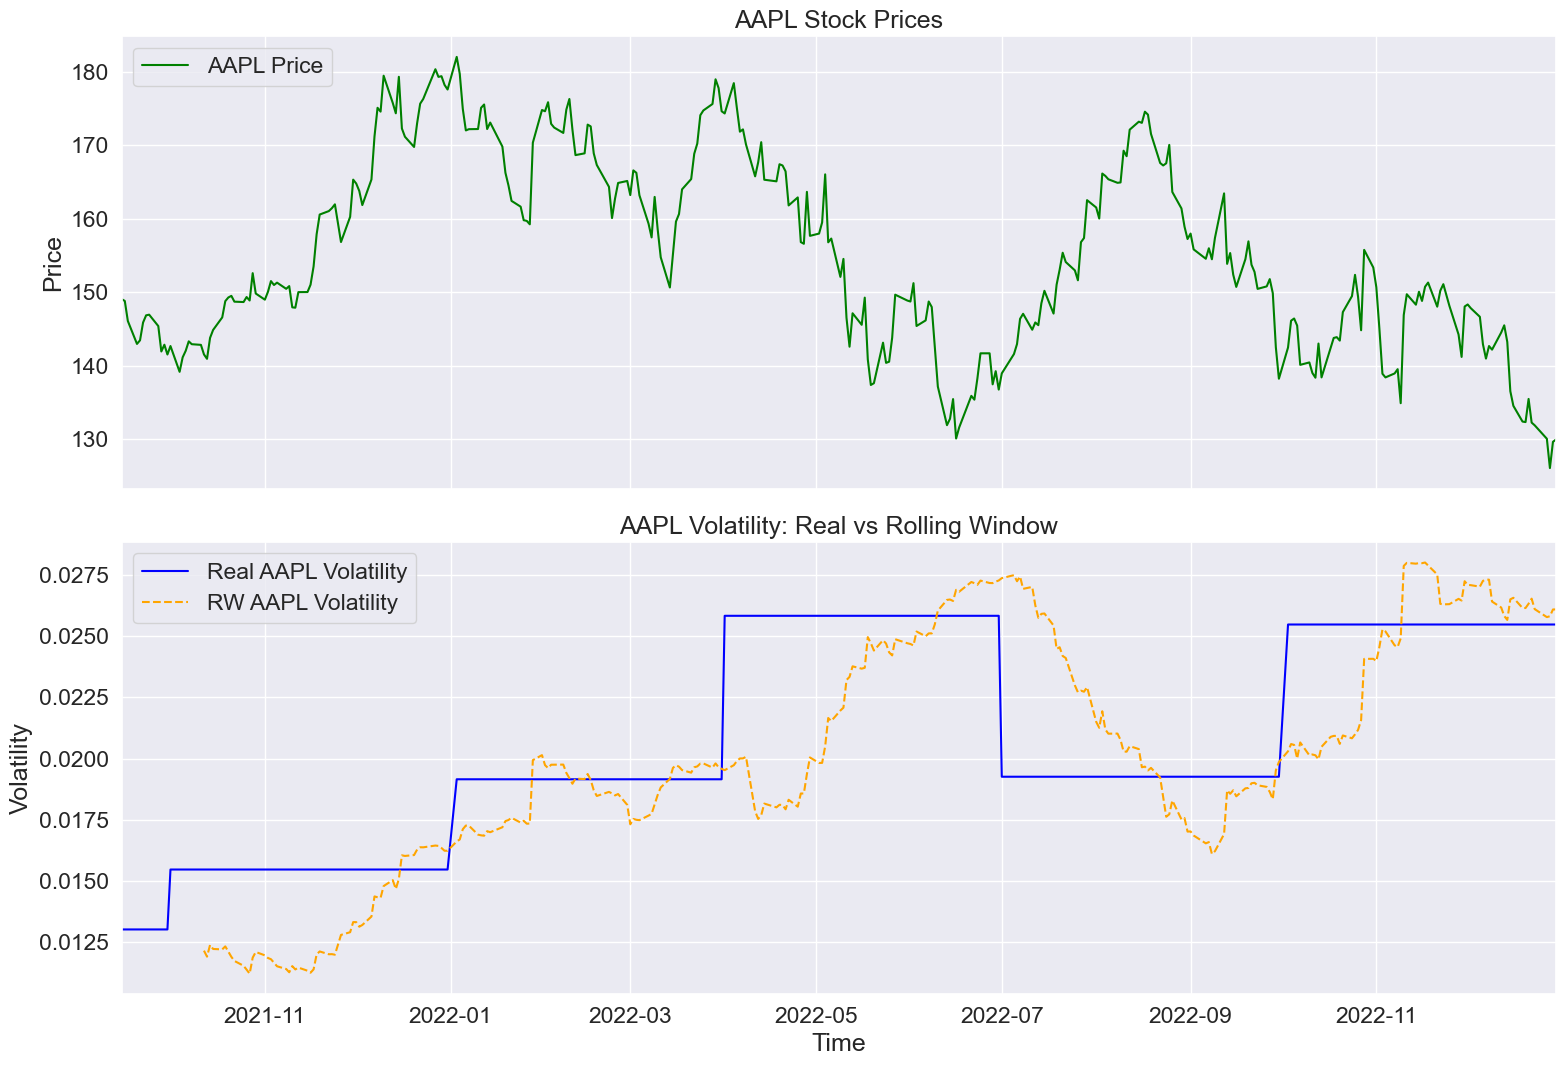

In [48]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_rw(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')

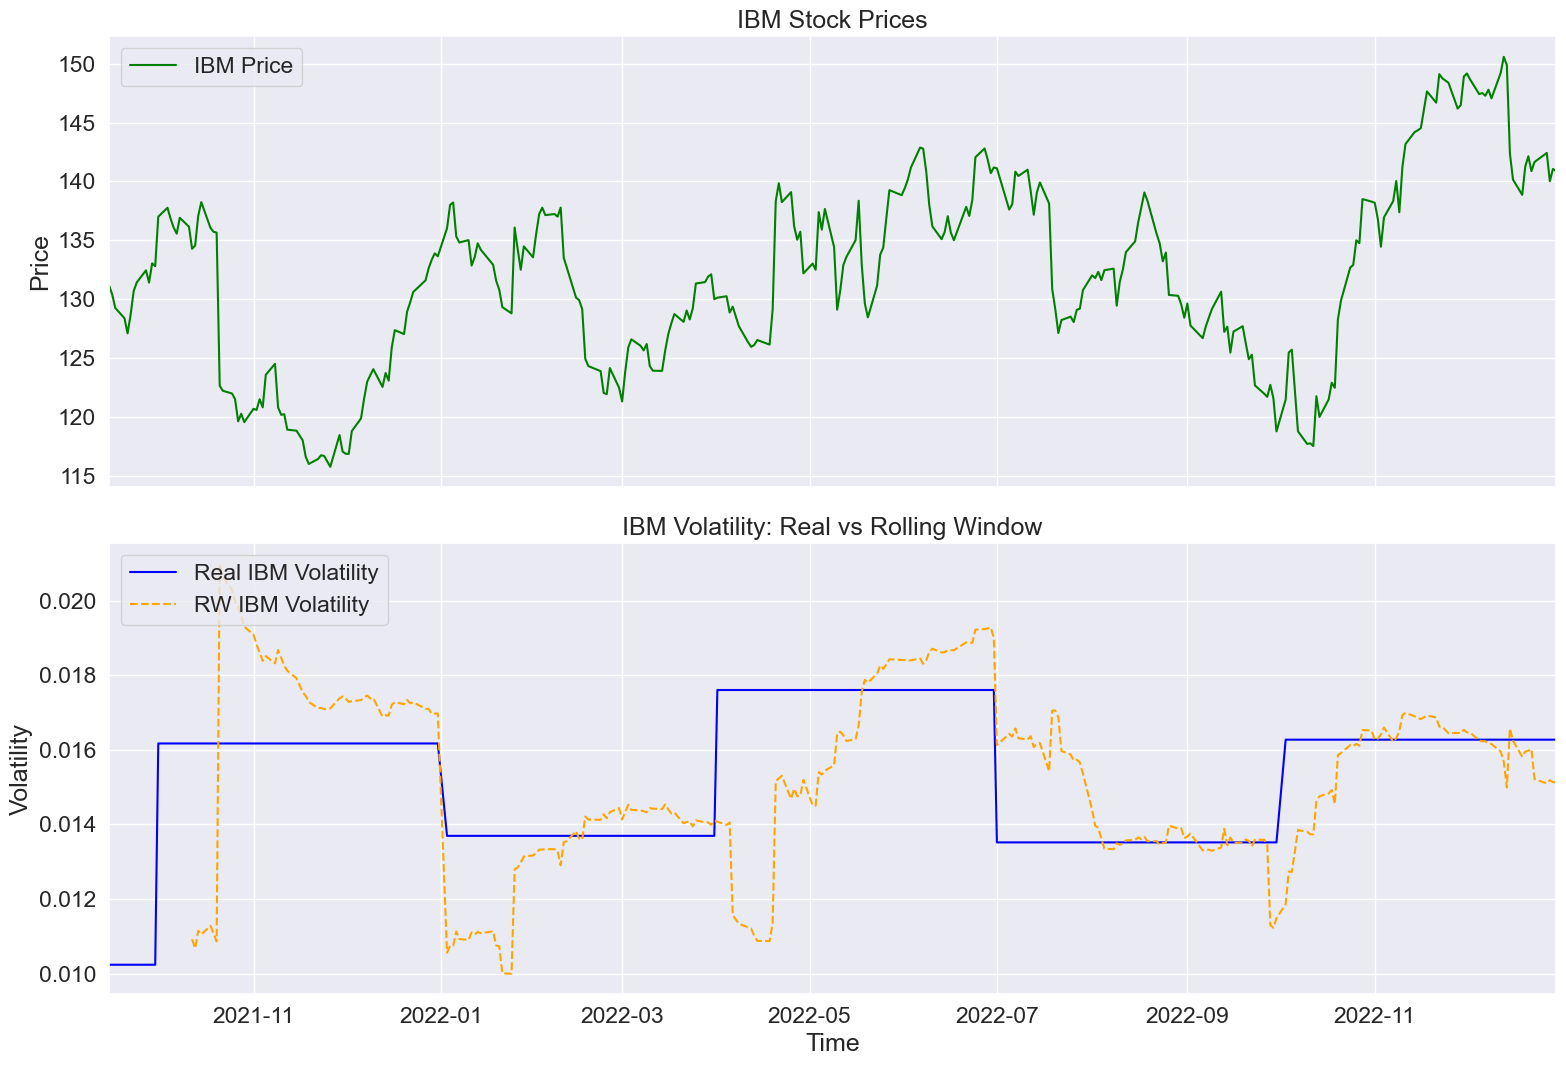

In [49]:
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_rw(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_rw_volatility_ibm['IBM Volatility'], 'IBM')

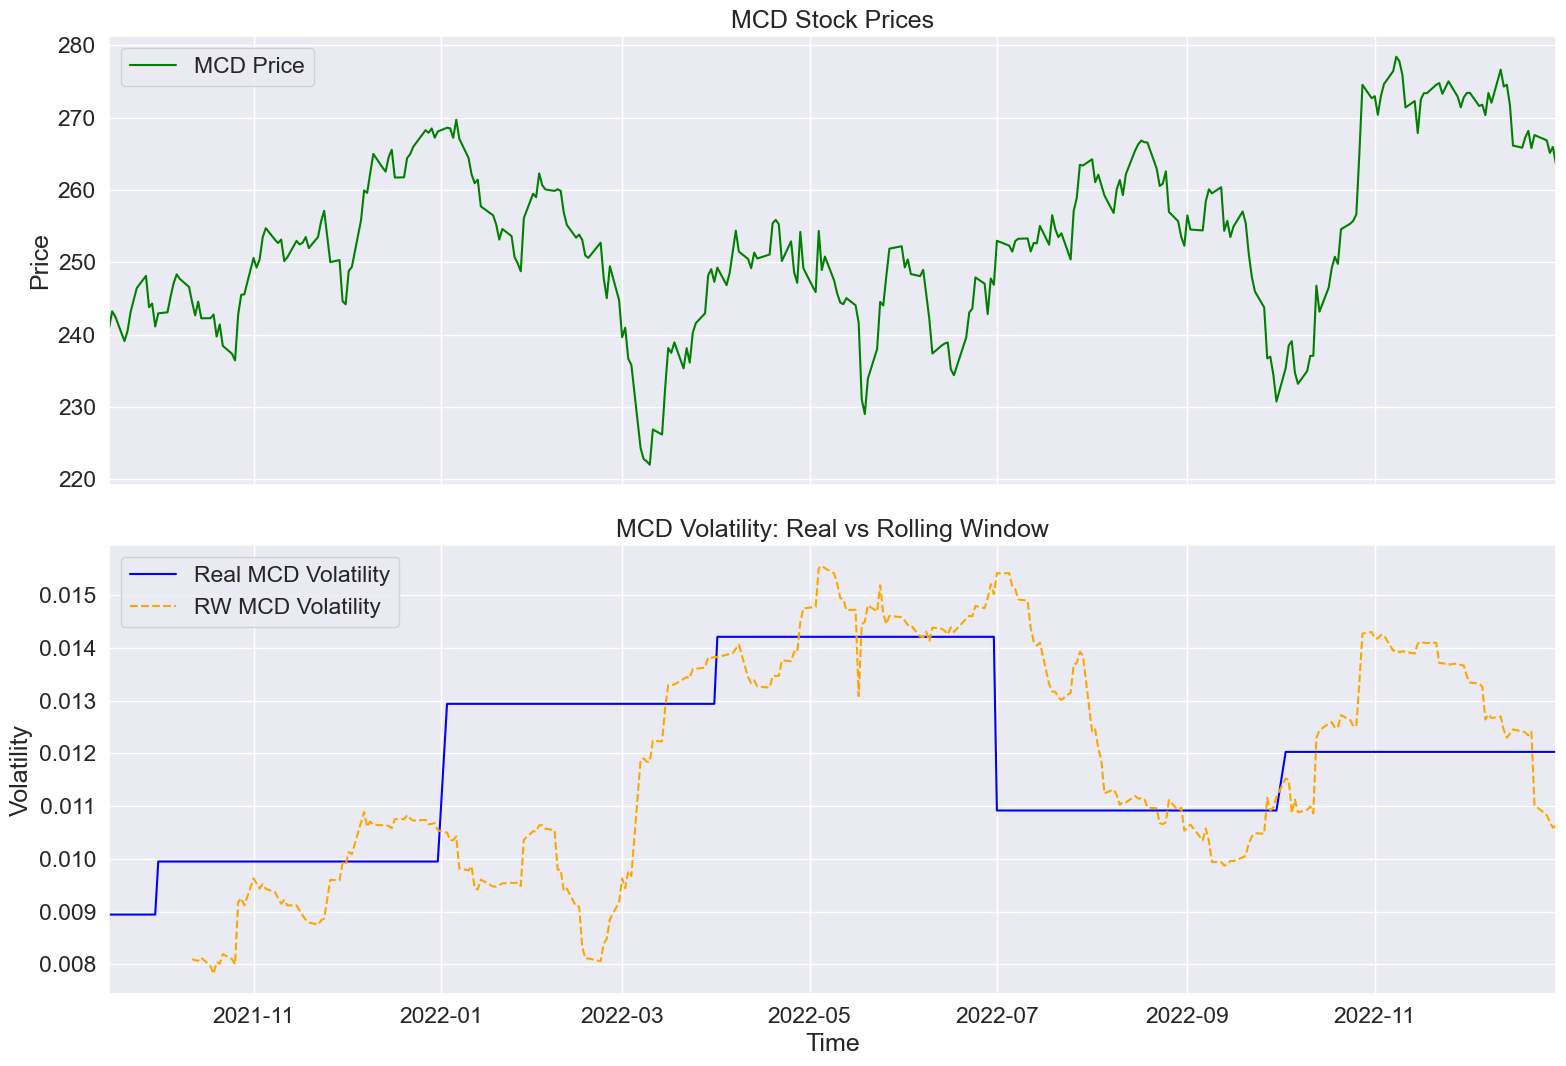

In [50]:
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_rw(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_rw_volatility_mcd['MCD Volatility'], 'MCD')

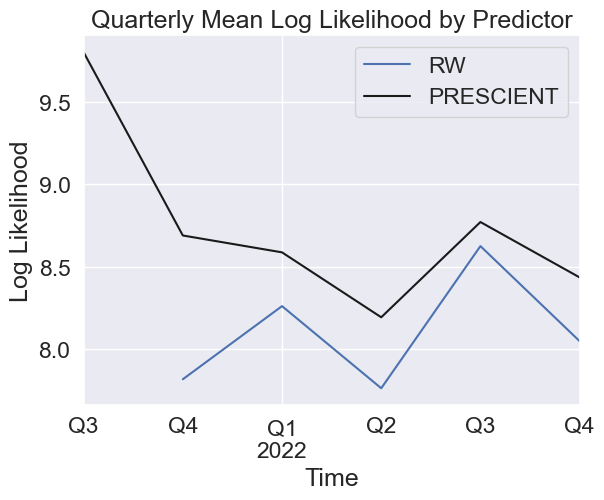



meanRegret: 0.400
stdRegret: 0.200
maxRegret: 0.800


meanLoglikelihoodRW: 8.100
stdLoglikelihoodRW: 0.300
maxLoglikelihoodRW: 8.600


meanLoglikelihoodPRESCIENT: 8.700
stdLoglikelihoodPRESCIENT: 0.500
maxLoglikelihoodPRESCIENT: 9.800

RW MSE
mean: 0.0000019028
std: 0.0000008528
max: 0.0000031096


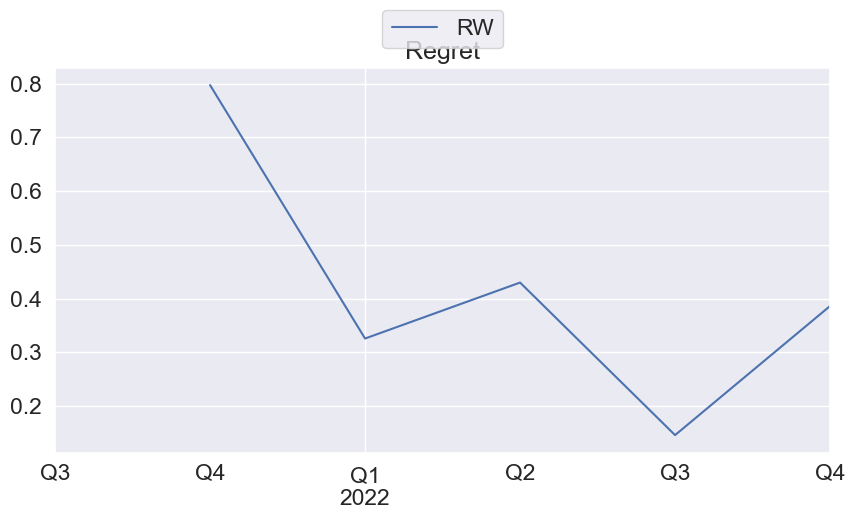

In [41]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["RW", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [rwDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        rwMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")


#
# MSEs
#

for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(testDataWithPercentageChange, predictorDict).resample("Q").mean()

        print("\n" + names[i] + " MSE")
        print(f"mean: {MSE_temp.mean():.10f}")
        print(f"std: {MSE_temp.std():.10f}")
        print(f"max: {MSE_temp.max():.10f}")
